# CLIP - Zero Shot Classifications

Author: Markus Pappert  
Date: 18.02.2022

This notebook should show how the new image classifier CLIP enables Zero-Shot Classification.  
This enables it to be used very cost efficiently in different industries.
In addition to conventional sensors CLIP could also be used to improve safety.  
Therefore I will try to use the OpenAIs CLIP model for different classifications.  

CLIP stands for "Contrastive Language–Image Pre-training" and is trained self-supervised, using a contrastive loss.

## Imports

In [1]:
import os
import datetime

import numpy as np
import torch
import clip
import cv2
from sklearn.metrics import confusion_matrix
from PIL import Image
from glob import glob

from tabulate import tabulate
from typing import List

import IPython.display
from IPython.display import Markdown, display
import ipywidgets as widgets

DATA_PATH_CARS        = '.\\Data\\Cars'
DATA_PATH_TEMP        = '.\\tmp'
DATA_PATH_VIDEOS      = '.\\Data\\Videos'

now = datetime.datetime.now()
print('Last notebook execution:')
print('User: {}'.format(os.getlogin()))
print('Date: {}.{}.{}'.format(now.day, now.month, now.year))
print('Time: {}:{}:{}\n'.format(now.hour, now.minute, now.second))

c:\Users\mpappert\Anaconda3\envs\DL\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Last notebook execution:
User: mpappert
Date: 12.8.2022
Time: 16:36:37



## CLIP

### What is CLIP

CLIP is a multimodal classifier for texts and images.  
It is trained self-supervised over a vast amount of text paired with images found across the internet (1).  
The text is encoded using a Transformers model. The images are encoded using one of different models from ResNet-50 to Vision Transformers.  
In the training step CLIP is then given an image and trained to predict which out of a set of 32,768 randomly sampled text snippets, was actually paired with it in the training dataset.  
Then the product of the latent space output of both encoders is maximized for correct training examples and minimized in counterexamples.

In the classification step multiple text snippets describing the classes are generated and encoded (2).  
Afterwards zero-shot predictions on images can be made by encoding the image and matching the latent space vectors of both the image and the text encoders (3).

CLIP, thus, allows engineers to design their own classifiers and removes the need for collecting task-specific training data and training.

More on Clip: https://openai.com/blog/clip/  


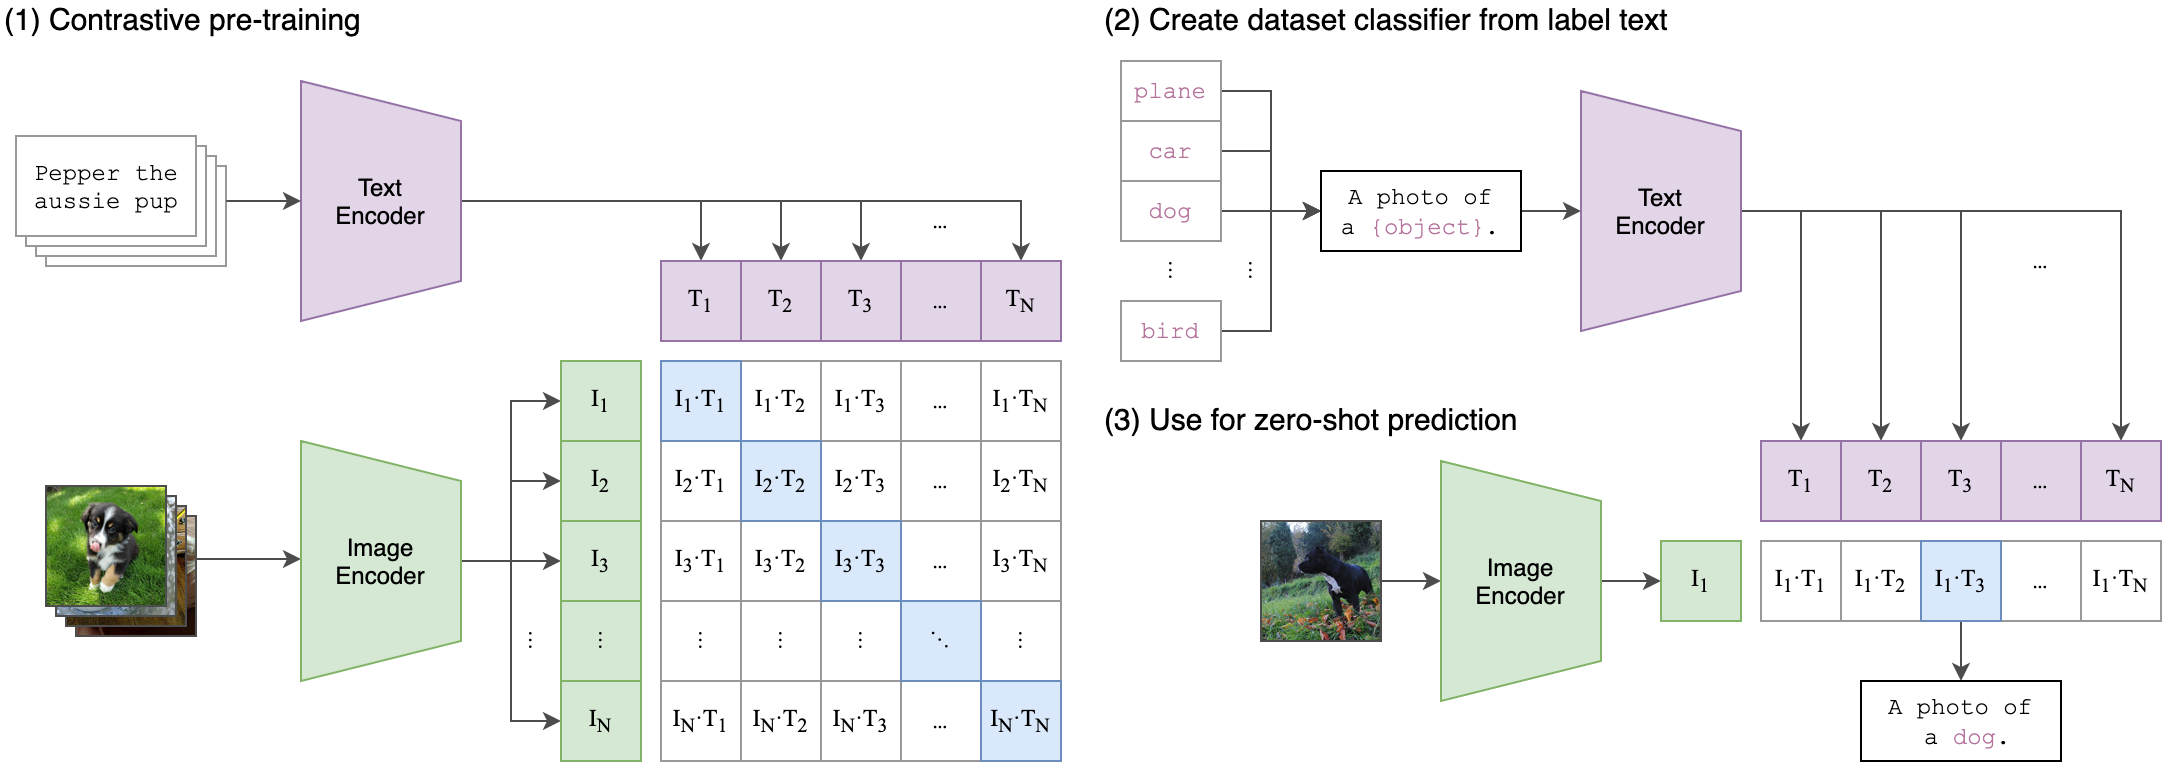

In [2]:
IPython.display.Image("./CLIP.png", width=1200)

### Load Model

In [3]:
# List available vision models for CLIP
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14']

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)

### Classification Function

In [5]:
def clip_classify(image: torch.Tensor, classes: List[str], model:clip.model.CLIP=model) -> int:
    """
    Classifies an "image" into "classes", using a CLIP-model "model".

    :param image:   a torch Tensor representing the image to be classified.
    :param classes: a list of strings representing the classes.
    :param model:   a CLIP-model object that is used to classify the image.
    :return:        returns the index of the class that has the highest probability.

    Markus Pappert
    16.02.2021
    """ 
    text = clip.tokenize(classes).to(device)

    with torch.no_grad():        
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Print Prdictions and probabilities
    class_prob_list = [(c,round(p, ndigits=3)) for c,p in zip(classes, probs.tolist()[0])]
    class_prob_list = sorted(class_prob_list, key = lambda x: x[1], reverse = True)
    print(tabulate(class_prob_list, headers=["Class", "Probability"]))

    return probs.argmax()

### Helper Functions

In [6]:
def show_normalized_image(image: torch.Tensor, new_height:int=150) -> None:
    """
    Resizes the Picture to a fixed height and keeps the original ratio.

    :param image:       a torch Tensor representing the image to scaled.
    :param new_height:  the new height of the image.
    :return:            displays the scaled image.

    Markus Pappert
    16.02.2021
    """ 
    width, height = image.size
    ratio = new_height/height
    new_width = int(ratio*width)
    display(image.resize((new_width,new_height)))

In [7]:
def printmd(string: str) -> None:
    """
    Displays a string in Markdown.

    :param string: the string to be displayed in Markdown.
    :return:       displays the Markdown.

    Markus Pappert
    16.02.2021
    """ 
    display(Markdown(string))

In [8]:
def make_dataset(path:str = '.\Data', verbose:bool = True) -> tuple:
    """
    Takes a folderpath as input and returns all image names (*.jpg and *.png), 
    the images and a preprocessed versions of the images (preprocessed for CLIP).

    :param path:    the folderpath to the images.
    :param verbose: if True, prints the image names
    :return:     returns the image names, the images and the preprocessed images.

    Markus Pappert
    16.02.2021
    """ 
    path = path if path[-1]=="\\" else path + "\\"
    ImagePaths = []
    for ext in ('*.jpg', '*.png'):
        ImagePaths.extend(glob(path + ext))
    
    ImagePaths  = sorted(ImagePaths)
    ImageNames  = [ImagePaths[i].split('\\')[-1] for i in range(len(ImagePaths))]
    Images      = [Image.open(ImagePaths[i]) for i in range(len(ImagePaths))]
    ImagesPre   = [preprocess(Images[i]).unsqueeze(0).to(device) for i in range(len(ImagePaths))] # Images Preprocessed for CLIP

    if verbose:
        print(*ImageNames, sep="\n")
    return ImageNames, Images, ImagesPre

In [9]:
def vid2img(path: str, sampling_rate: float = 1, verbose: bool = True) -> int:
    """
    Takes a video "path" as input and extracts images with "sampling_rate" images per second.
    If "sampling_rate" == -1 then every image from the video is extracted.

    :param path:          the path to the video.
    :param sampling_rate: There will be "sampling_rate" much images created per second video. 
    :param verbose:       if True, prints the image names
    :return:     saves the images from the video to ".\tmp\", and returns number of extracted images.

    Markus Pappert
    16.02.2021
    """ 
    vid = cv2.VideoCapture(path)
    try:
        # creating a folder named data
        if not os.path.exists('tmp'):
            os.makedirs('tmp')
    # if not created then raise error
    except OSError:
        print ('Error: Creating directory of tmp')

    fps = int(vid.get(cv2.CAP_PROP_FPS))
    currentframe = 0

    while(True):
        # reading one frame
        ret,frame = vid.read()
    
        if ret:
            # if video is still left continue creating images
            name = './tmp/frame' + str(currentframe).zfill(4) + '.jpg'
            if verbose:
                print ('Creating...' + name)
            cv2.imwrite(name, frame)
            currentframe += 1
        else:
            break

        #skip some frames to get sampling of 1Hz
        if sampling_rate != -1:
            i = 0
            for i in range(max(int(fps/sampling_rate) - 1, 0)):
                ret,frame = vid.read()
                if not ret:
                    break
    
    # Release all space and windows once done
    vid.release()
    cv2.destroyAllWindows()

    return currentframe

## Case Study 1: Recognizing burning cars

In search of a useful application, I thought we could try to automatically detect burning cars.  
Perhaps this detection could be used in dashcams.   
If a fire is detected on the road, the driver is asked, if the fire department should be informed.  
So let's see, if CLIP can do this without specific training:

### Load Dataset

In [10]:
ImageNames, Images, ImagesPre = make_dataset(DATA_PATH_CARS)

01_Car.jpg
02_Car.jpg
03_Car.jpg
04_Car.jpg
05_Car.jpg
06_Car.jpg
07_Car.jpg
08_Car.jpg
09_Car.jpg
10_Car.jpg
11_Burning_Car.jpg
12_Burning_Car.png
13_Burning_Car.jpg
14_Burning_Car.jpg
15_Burning_Car.jpg
16_Burning_Car.jpg
17_Burning_Car.jpg
18_Burning_Car.jpg
19_Burning_Car.jpg
20_Burning_Car.jpg
21_Burning_Car.jpg
22_Burning_Car.jpg
23_Burning_Car.png


### Define Classes
Now the classes to be classified are defined:

In [11]:
Classes = ["A picture of a car", "A picture of a burning car"]

### Classify Images

#### Classification of 01_Car.jpg:

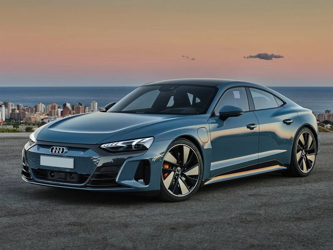

Class                         Probability
--------------------------  -------------
A picture of a car                  0.912
A picture of a burning car          0.088



Correct Classification!

#### Classification of 02_Car.jpg:

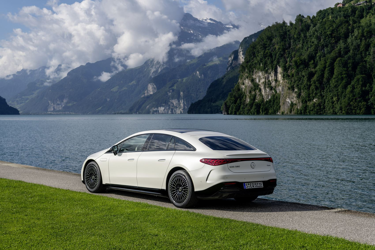

Class                         Probability
--------------------------  -------------
A picture of a car                   0.98
A picture of a burning car           0.02



Correct Classification!

#### Classification of 03_Car.jpg:

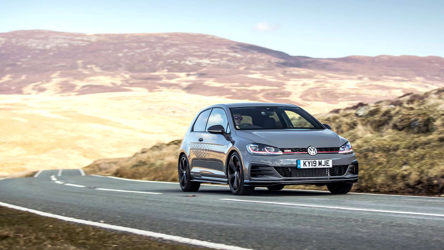

Class                         Probability
--------------------------  -------------
A picture of a car                  0.947
A picture of a burning car          0.053



Correct Classification!

#### Classification of 04_Car.jpg:

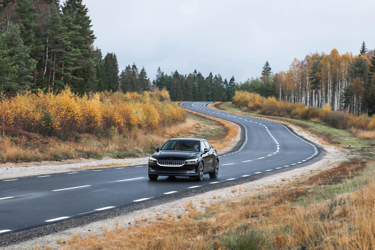

Class                         Probability
--------------------------  -------------
A picture of a car                  0.987
A picture of a burning car          0.013



Correct Classification!

#### Classification of 05_Car.jpg:

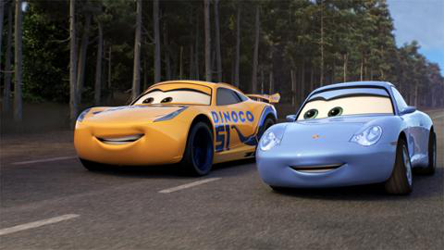

Class                         Probability
--------------------------  -------------
A picture of a car                  0.931
A picture of a burning car          0.069



Correct Classification!

#### Classification of 06_Car.jpg:

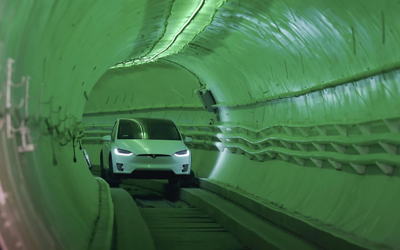

Class                         Probability
--------------------------  -------------
A picture of a car                   0.99
A picture of a burning car           0.01



Correct Classification!

#### Classification of 07_Car.jpg:

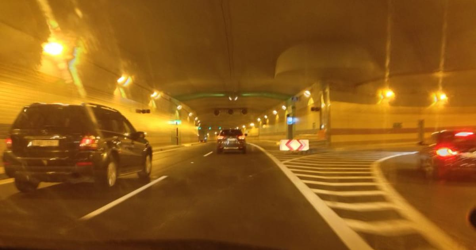

Class                         Probability
--------------------------  -------------
A picture of a car                  0.965
A picture of a burning car          0.035



Correct Classification!

#### Classification of 08_Car.jpg:

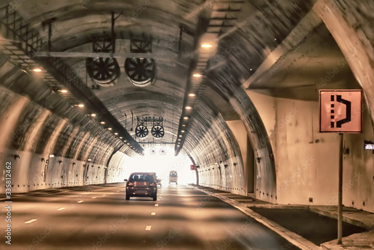

Class                         Probability
--------------------------  -------------
A picture of a car                  0.979
A picture of a burning car          0.021



Correct Classification!

#### Classification of 09_Car.jpg:

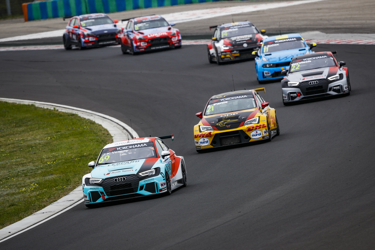

Class                         Probability
--------------------------  -------------
A picture of a car                  0.992
A picture of a burning car          0.008



Correct Classification!

#### Classification of 10_Car.jpg:

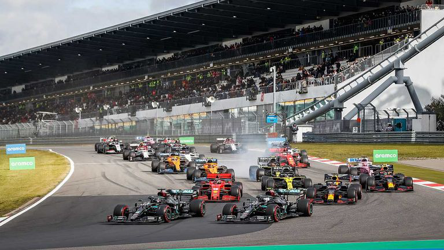

Class                         Probability
--------------------------  -------------
A picture of a car                   0.87
A picture of a burning car           0.13



Correct Classification!

#### Classification of 11_Burning_Car.jpg:

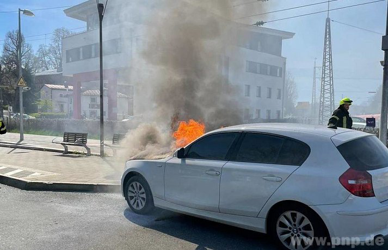

Class                         Probability
--------------------------  -------------
A picture of a burning car              1
A picture of a car                      0



Correct Classification!

#### Classification of 12_Burning_Car.png:

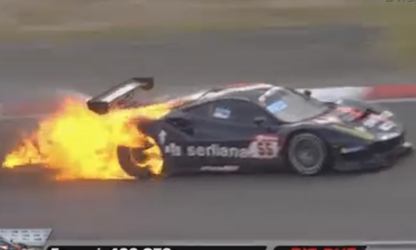

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.998
A picture of a car                  0.002



Correct Classification!

#### Classification of 13_Burning_Car.jpg:

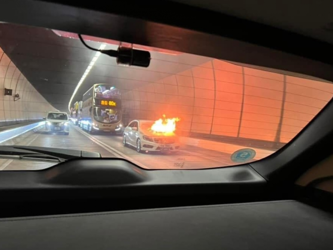

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.997
A picture of a car                  0.003



Correct Classification!

#### Classification of 14_Burning_Car.jpg:

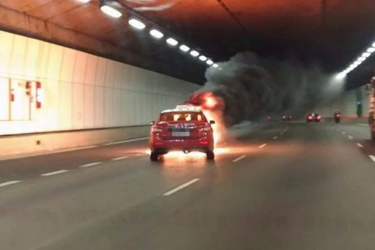

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.999
A picture of a car                  0.001



Correct Classification!

#### Classification of 15_Burning_Car.jpg:

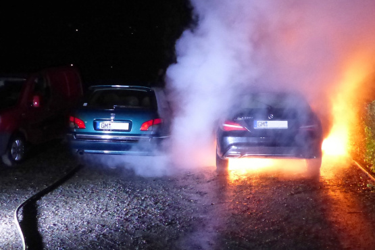

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.999
A picture of a car                  0.001



Correct Classification!

#### Classification of 16_Burning_Car.jpg:

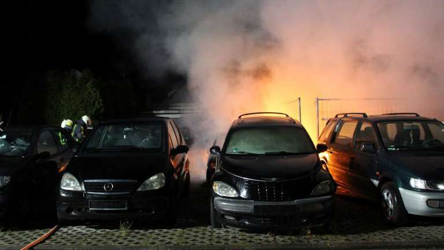

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.994
A picture of a car                  0.006



Correct Classification!

#### Classification of 17_Burning_Car.jpg:

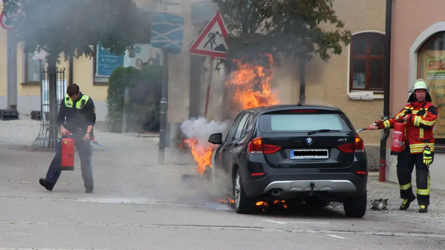

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.998
A picture of a car                  0.002



Correct Classification!

#### Classification of 18_Burning_Car.jpg:

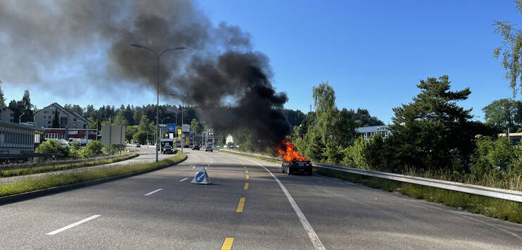

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.998
A picture of a car                  0.002



Correct Classification!

#### Classification of 19_Burning_Car.jpg:

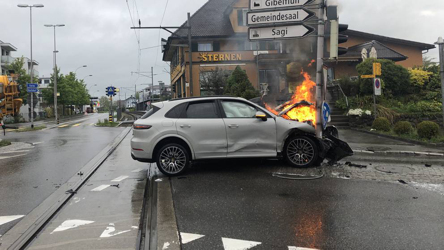

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.995
A picture of a car                  0.005



Correct Classification!

#### Classification of 20_Burning_Car.jpg:

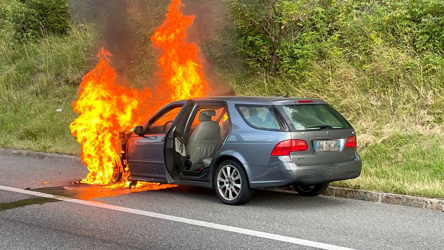

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.987
A picture of a car                  0.013



Correct Classification!

#### Classification of 21_Burning_Car.jpg:

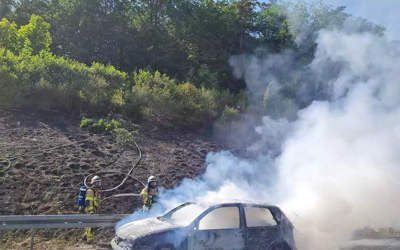

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.998
A picture of a car                  0.002



Correct Classification!

#### Classification of 22_Burning_Car.jpg:

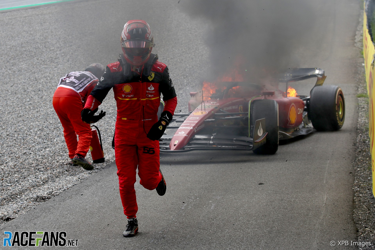

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.999
A picture of a car                  0.001



Correct Classification!

#### Classification of 23_Burning_Car.png:

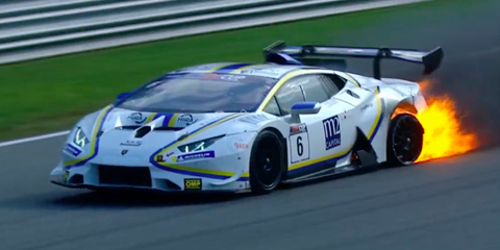

Class                         Probability
--------------------------  -------------
A picture of a car                  0.939
A picture of a burning car          0.061

Wrong Classification!


In [12]:
# Vectors for Confusion matrix
y_true = np.r_[np.zeros(10), np.ones(len(ImageNames)-10)]
y_pred = np.ones(len(ImageNames)) * np.NaN

# Classify all images
for i in range(len(ImageNames)):
    printmd('#### Classification of {}:'.format(ImageNames[i]))
    show_normalized_image(Images[i], 250)
    c = clip_classify(ImagesPre[i], Classes)
    print("")

    y_pred[i] = c
    if y_true[i] == y_pred[i]:
        printmd("Correct Classification!")
    else:
        print("Wrong Classification!")

#### Confusion Matrix

In [13]:
confusion_matrix(y_true, y_pred)

array([[10,  0],
       [ 1, 12]], dtype=int64)

The result is very good!  
We have only one false negative classification.

## Case Study 2: Recognizing from Videos
From videos we can also recognize different objects, actions, changes in state of matter, etc.

### Choose and create Dataset (Images) from Video

In [14]:
actual_video = DATA_PATH_VIDEOS + '\\' + 'Cars.mp4'
widgets.Video.from_file(actual_video, width=320, height=320)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00j.moov\x00\x00\x00lmvhd\x00\x00\x00…

In [15]:
vid2img(actual_video, sampling_rate=0.3, verbose=True)

Creating..../tmp/frame0000.jpg
Creating..../tmp/frame0001.jpg
Creating..../tmp/frame0002.jpg
Creating..../tmp/frame0003.jpg
Creating..../tmp/frame0004.jpg
Creating..../tmp/frame0005.jpg
Creating..../tmp/frame0006.jpg
Creating..../tmp/frame0007.jpg
Creating..../tmp/frame0008.jpg
Creating..../tmp/frame0009.jpg
Creating..../tmp/frame0010.jpg
Creating..../tmp/frame0011.jpg
Creating..../tmp/frame0012.jpg
Creating..../tmp/frame0013.jpg
Creating..../tmp/frame0014.jpg
Creating..../tmp/frame0015.jpg
Creating..../tmp/frame0016.jpg
Creating..../tmp/frame0017.jpg
Creating..../tmp/frame0018.jpg
Creating..../tmp/frame0019.jpg
Creating..../tmp/frame0020.jpg
Creating..../tmp/frame0021.jpg
Creating..../tmp/frame0022.jpg


23

In [16]:
ImageNames, Images, ImagesPre = make_dataset(DATA_PATH_TEMP, verbose=False)

### Define Classes

In [17]:
Classes = ["A picture of a car", "A picture of a burning car"]

### Classify Images

#### Classification of frame0000.jpg:

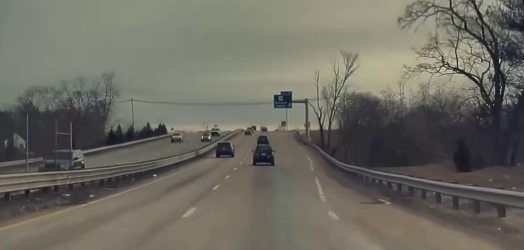

Class                         Probability
--------------------------  -------------
A picture of a car                   0.74
A picture of a burning car           0.26



#### Classification of frame0001.jpg:

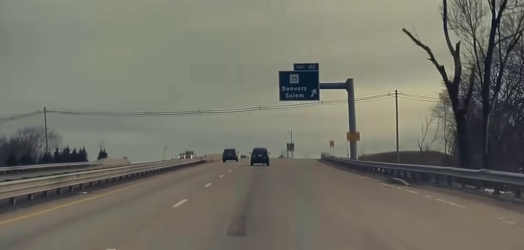

Class                         Probability
--------------------------  -------------
A picture of a car                  0.787
A picture of a burning car          0.213



#### Classification of frame0002.jpg:

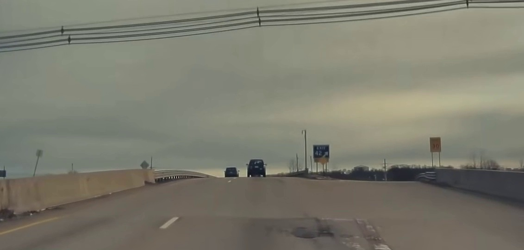

Class                         Probability
--------------------------  -------------
A picture of a car                   0.77
A picture of a burning car           0.23



#### Classification of frame0003.jpg:

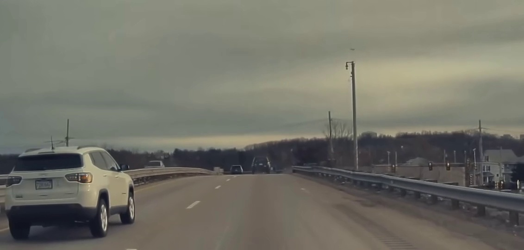

Class                         Probability
--------------------------  -------------
A picture of a car                  0.632
A picture of a burning car          0.368



#### Classification of frame0004.jpg:

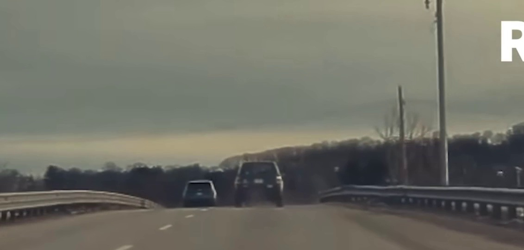

Class                         Probability
--------------------------  -------------
A picture of a car                  0.723
A picture of a burning car          0.277



#### Classification of frame0005.jpg:

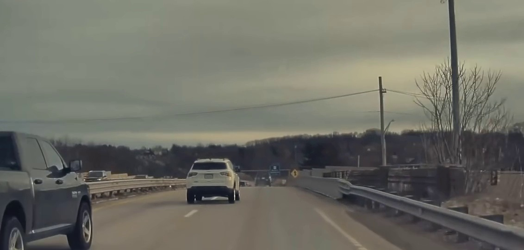

Class                         Probability
--------------------------  -------------
A picture of a car                  0.852
A picture of a burning car          0.148



#### Classification of frame0006.jpg:

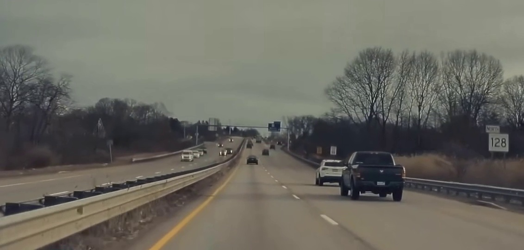

Class                         Probability
--------------------------  -------------
A picture of a car                   0.92
A picture of a burning car           0.08



#### Classification of frame0007.jpg:

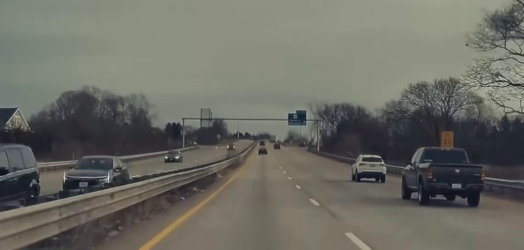

Class                         Probability
--------------------------  -------------
A picture of a car                  0.903
A picture of a burning car          0.097



#### Classification of frame0008.jpg:

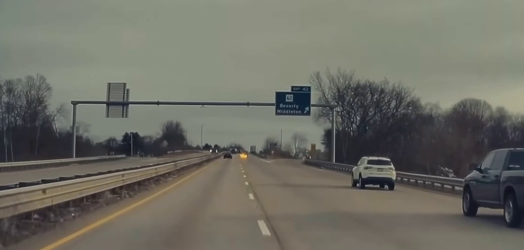

Class                         Probability
--------------------------  -------------
A picture of a car                  0.842
A picture of a burning car          0.158



#### Classification of frame0009.jpg:

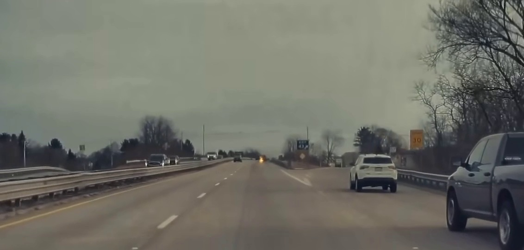

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.552
A picture of a car                  0.448



#### Classification of frame0010.jpg:

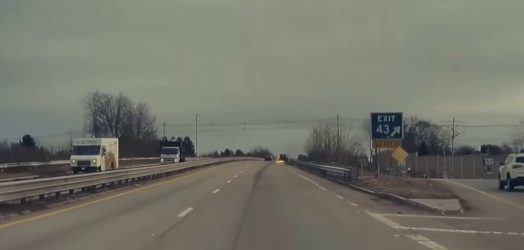

Class                         Probability
--------------------------  -------------
A picture of a car                  0.522
A picture of a burning car          0.478



#### Classification of frame0011.jpg:

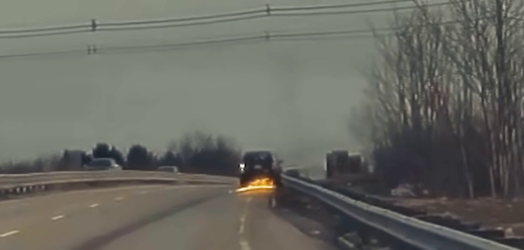

Class                         Probability
--------------------------  -------------
A picture of a burning car           0.97
A picture of a car                   0.03



#### Classification of frame0012.jpg:

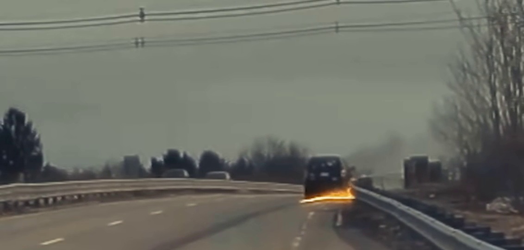

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.975
A picture of a car                  0.025



#### Classification of frame0013.jpg:

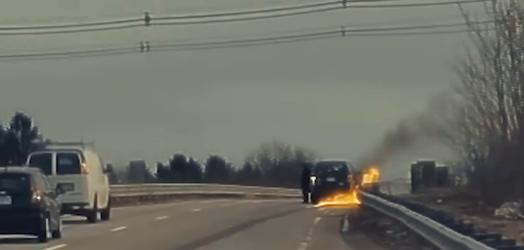

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.995
A picture of a car                  0.005



#### Classification of frame0014.jpg:

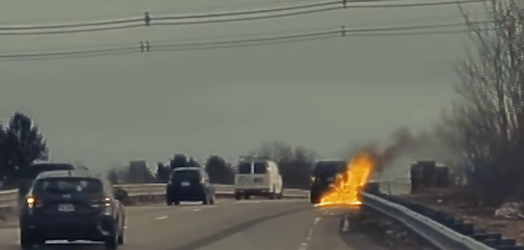

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.996
A picture of a car                  0.004



#### Classification of frame0015.jpg:

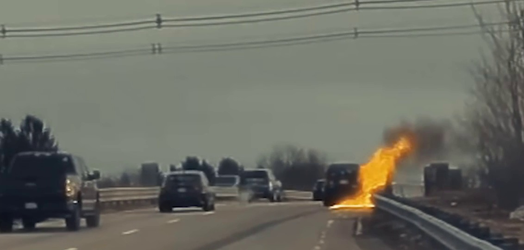

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.996
A picture of a car                  0.004



#### Classification of frame0016.jpg:

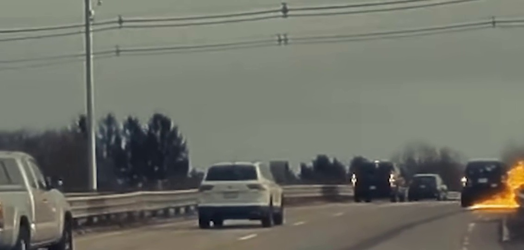

Class                         Probability
--------------------------  -------------
A picture of a car                  0.794
A picture of a burning car          0.206



#### Classification of frame0017.jpg:

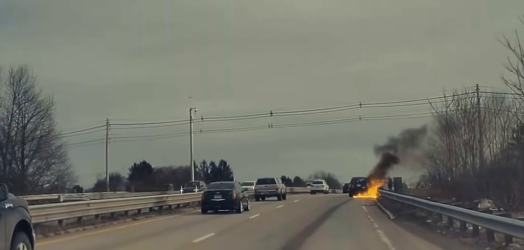

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.995
A picture of a car                  0.005



#### Classification of frame0018.jpg:

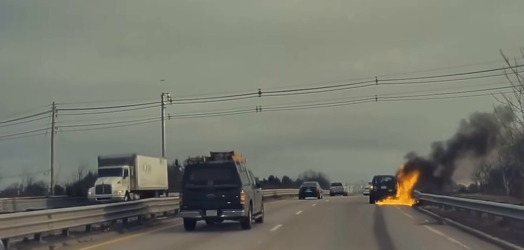

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.945
A picture of a car                  0.055



#### Classification of frame0019.jpg:

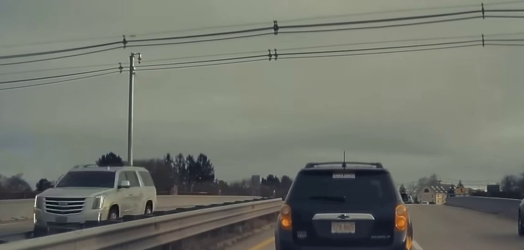

Class                         Probability
--------------------------  -------------
A picture of a car                  0.794
A picture of a burning car          0.206



#### Classification of frame0020.jpg:

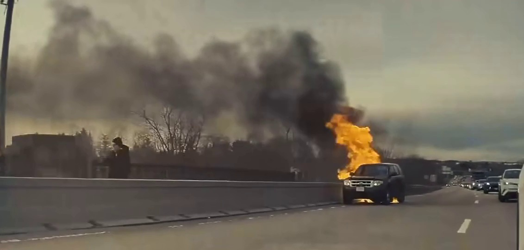

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.996
A picture of a car                  0.004



#### Classification of frame0021.jpg:

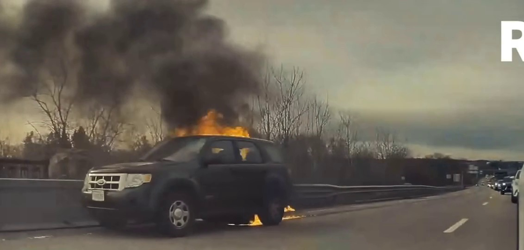

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.997
A picture of a car                  0.003



#### Classification of frame0022.jpg:

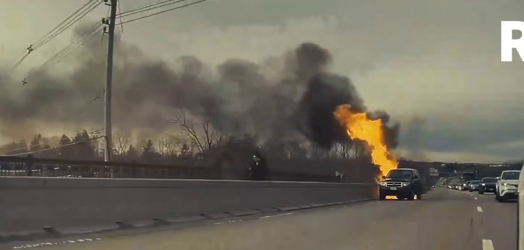

Class                         Probability
--------------------------  -------------
A picture of a burning car          0.997
A picture of a car                  0.003



In [18]:
for i in range(len(ImageNames)):
    printmd('#### Classification of {}:'.format(ImageNames[i]))
    show_normalized_image(Images[i], 250)
    c = clip_classify(ImagesPre[i], Classes)
    print("")

# delete temporary files
files_to_delete = glob(DATA_PATH_TEMP +'\\' + '*.*')
for file in files_to_delete:
    os.remove(file) 

# Summary

* CLIP allows us to do image classifications of every kind without training.
* that means also without costly gathering lots of training examples.
* the CLIP classifier is more of a generalist, than a specialist.
* (to get even better classifications, it is possible to do transfer learning on top of the image embedding latent vector)
* The big vision transformers models seem to have better overall accuracy but they need more processing time (6s on my CPU (i5 6300U)).
* For realtime implementation a faster CPU, a smaller vision model or a GPU (or an embedded AI computing platform like NVidia Jetson), would be needed.
* If the images in the test dataset were collected using for example Google Image Search, there is a risk that they have already been used to train CLIP.  
  Therefore it makes sense to use recently uploaded images and images that were extracted from videos.  
  Otherwise we cannot rely on the results. We would end up with a false impression of a better model accuracy.